In [1]:
from google.colab import drive
import os
drive.mount('/content/gdrive')

root_path = 'gdrive/My Drive/Colab Notebooks/' #change dir to your project folder

os.chdir('/content/' + root_path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import keras
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

#from clr import LRFinder,OneCycleLR
#!git clone https://github.com/bckenstler/CLR.git
  
#from CLR.clr_callback import *

import resnet

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

from keras.layers import GlobalAveragePooling2D

from keras import optimizers

from keras import regularizers

import cv2

from sklearn.metrics import accuracy_score

import numpy as np

import warnings

warnings.filterwarnings("ignore")



Using TensorFlow backend.


In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

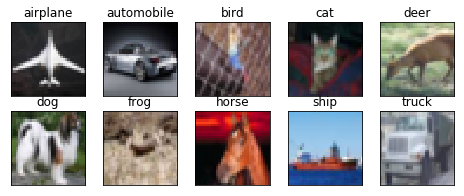

In [4]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
train_labels_integer = train_labels

test_labels_integer = test_labels

for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels_integer[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(iterator, model):
    
    accuracy = model.evaluate_generator(iterator, steps=len(iterator))[1]
    return (accuracy * 100)
  
def tta_preds(img, model, data_gen, num_aug_images):
  
  img = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
  
  images = data_gen.flow(img, batch_size=num_aug_images)
  
  predictions = model.predict_generator(images, steps=num_aug_images)
  
  prediction_mean = np.mean(predictions, axis=0)
  
  return np.argmax(prediction_mean)


def tta_accuracy(model, X, Y, data_gen, num_aug_images=5):
  
  yhats=[]
  
  for i in range(len(X)):
      
        yhat = tta_preds(X[i], model, data_gen, num_aug_images)

        yhats.append(yhat)
    
  testY_labels = np.argmax(Y, axis=1)
    
  acc = accuracy_score(testY_labels, yhats)
    
  return acc

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
import numpy as np
from keras.callbacks import Callback

def get_random_eraser_and_crop(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, random_crop_size=(32, 32), padding_for_crop=4,pixel_level=False):
  
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img
      
    def random_crop(input_img):
        
        # Note: image_data_format is 'channel_last'
        assert input_img.shape[2] == 3
        
        img = cv2.copyMakeBorder(input_img, padding_for_crop, padding_for_crop, padding_for_crop, padding_for_crop, cv2.BORDER_REPLICATE)
        
        height, width = img.shape[0], img.shape[1]
        
        dy, dx = random_crop_size
        
        x = np.random.randint(0, width - dx + 1)
        
        y = np.random.randint(0, height - dy + 1)
        
        return img[y:(y+dy), x:(x+dx), :]
      
    def do_preproc(input_image):
      
      return eraser(random_crop(input_image))
      
    return do_preproc
  
class LR_Finder(Callback):
    
    def __init__(self, start_lr=1e-5, end_lr=10, step_size=None, beta=.98):
        super().__init__()
        
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.step_size = step_size
        self.beta = beta
        self.lr_mult = (end_lr/start_lr)**(1/step_size)
        
    def on_train_begin(self, logs=None):
        self.best_loss = 1e9
        self.avg_loss = 0
        self.losses, self.smoothed_losses, self.lrs, self.iterations = [], [], [], []
        self.iteration = 0
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.start_lr)
        
    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        
        self.iteration += 1
        
        self.avg_loss = self.beta * self.avg_loss + (1 - self.beta) * loss
        smoothed_loss = self.avg_loss / (1 - self.beta**self.iteration)
        
        # Check if the loss is not exploding
        if self.iteration>1 and smoothed_loss > self.best_loss * 3:
            self.model.stop_training = True
            return

        if smoothed_loss < self.best_loss or self.iteration==1:
            self.best_loss = smoothed_loss
        
        lr = self.start_lr * (self.lr_mult**self.iteration)
        
        #print(self.iteration, loss, lr)
        
        self.losses.append(loss)
        self.smoothed_losses.append(smoothed_loss)
        self.lrs.append(lr)
        self.iterations.append(self.iteration)
        
        
        K.set_value(self.model.optimizer.lr, lr)  
        
    def plot_lr(self):
        plt.xlabel('Iterations')
        plt.ylabel('Learning rate')
        plt.plot(self.iterations, self.lrs)
        
    def plot(self, n_skip=10):
        plt.ylabel('Loss')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_smoothed_loss(self, n_skip=10):
        plt.ylabel('Smoothed Losses')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.smoothed_losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_loss(self):
        plt.ylabel('Losses')
        plt.xlabel('Iterations')
        plt.plot(self.iterations[10:], self.losses[10:])
        
        
class CyclicLR(keras.callbacks.Callback):
    
    def __init__(self,base_lr, max_lr, step_size, base_m, max_m, cyclical_momentum):
 
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.base_m = base_m
        self.max_m = max_m
        self.cyclical_momentum = cyclical_momentum
        self.step_size = step_size
        
        self.clr_iterations = 0.
        self.cm_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}
        
    def clr(self):
        
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        
        if cycle == 2:
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)          
            return self.base_lr-(self.base_lr-self.base_lr/100)*np.maximum(0,(1-x))
        
        else:
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0,(1-x))
    
    def cm(self):
        
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        
        if cycle == 2:
            
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1) 
            return self.max_m
        
        else:
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
            return self.max_m - (self.max_m-self.base_m)*np.maximum(0,(1-x))
        
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())
            
        if self.cyclical_momentum == True:
            if self.clr_iterations == 0:
                K.set_value(self.model.optimizer.momentum, self.cm())
            else:
                K.set_value(self.model.optimizer.momentum, self.cm())
            
            
    def on_batch_begin(self, batch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)
        
        if self.cyclical_momentum == True:
            self.history.setdefault('momentum', []).append(K.get_value(self.model.optimizer.momentum))

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())
        
        if self.cyclical_momentum == True:
            K.set_value(self.model.optimizer.momentum, self.cm())
        
        
class showLR( Callback ) :
    
    time = time.time()
    
    def on_epoch_begin(self, epoch, logs=None):
        if epoch == 0:
          self.time = time.time()
          
          print("time registered", self.time)
          
        current_time = time.time()
        
        time_taken = current_time - self.time
        lr = float(K.get_value(self.model.optimizer.lr))
        print(" epoch={:02d}, lr={:.5f}, time_elapsed(s)={:.2f}".format( epoch, lr, time_taken))
        
class OneCycleLR(Callback):
    def __init__(self,
                 batch_size,
                 samples,
                 max_lr,
                 end_percentage=0.1,
                 scale_percentage=None,
                 maximum_momentum=0.95,
                 minimum_momentum=0.85,
                 verbose=True):
        """ This callback implements a cyclical learning rate policy (CLR).
        This is a special case of Cyclic Learning Rates, where we have only 1 cycle.
        After the completion of 1 cycle, the learning rate will decrease rapidly to
        100th its initial lowest value.

        # Arguments:
            max_lr: Float. Initial learning rate. This also sets the
                starting learning rate (which will be 10x smaller than
                this), and will increase to this value during the first cycle.
            end_percentage: Float. The percentage of all the epochs of training
                that will be dedicated to sharply decreasing the learning
                rate after the completion of 1 cycle. Must be between 0 and 1.
            scale_percentage: Float or None. If float, must be between 0 and 1.
                If None, it will compute the scale_percentage automatically
                based on the `end_percentage`.
            maximum_momentum: Optional. Sets the maximum momentum (initial)
                value, which gradually drops to its lowest value in half-cycle,
                then gradually increases again to stay constant at this max value.
                Can only be used with SGD Optimizer.
            minimum_momentum: Optional. Sets the minimum momentum at the end of
                the half-cycle. Can only be used with SGD Optimizer.
            verbose: Bool. Whether to print the current learning rate after every
                epoch.

        # Reference
            - [A disciplined approach to neural network hyper-parameters: Part 1 -- learning rate, batch size, weight_decay, and weight decay](https://arxiv.org/abs/1803.09820)
            - [Super-Convergence: Very Fast Training of Residual Networks Using Large Learning Rates](https://arxiv.org/abs/1708.07120)
        """
        super(OneCycleLR, self).__init__()
        
        #print(super.params)

        if end_percentage < 0. or end_percentage > 1.:
            raise ValueError("`end_percentage` must be between 0 and 1")

        if scale_percentage is not None and (scale_percentage < 0. or scale_percentage > 1.):
            raise ValueError("`scale_percentage` must be between 0 and 1")

        self.initial_lr = max_lr
        self.end_percentage = end_percentage
        self.scale = float(scale_percentage) if scale_percentage is not None else float(end_percentage)
        self.max_momentum = maximum_momentum
        self.min_momentum = minimum_momentum
        self.verbose = verbose

        if self.max_momentum is not None and self.min_momentum is not None:
            self._update_momentum = True
        else:
            self._update_momentum = False

        self.clr_iterations = 0.
        self.history = {}

        self.epochs = None
        self.batch_size = batch_size
        self.samples = samples
        self.steps = None
        self.num_iterations = None
        self.mid_cycle_id = None

    def _reset(self):
        """
        Reset the callback.
        """
        self.clr_iterations = 0.
        self.history = {}

    def compute_lr(self):
        """
        Compute the learning rate based on which phase of the cycle it is in.

        - If in the first half of training, the learning rate gradually increases.
        - If in the second half of training, the learning rate gradually decreases.
        - If in the final `end_percentage` portion of training, the learning rate
            is quickly reduced to near 100th of the original min learning rate.

        # Returns:
            the new learning rate
        """
        if self.clr_iterations > 2 * self.mid_cycle_id:
            current_percentage = (self.clr_iterations - 2 * self.mid_cycle_id)
            current_percentage /= float((self.num_iterations - 2 * self.mid_cycle_id))
            new_lr = self.initial_lr * (1. + (current_percentage *
                                              (1. - 100.) / 100.)) * self.scale

        elif self.clr_iterations > self.mid_cycle_id:
            current_percentage = 1. - (
                self.clr_iterations - self.mid_cycle_id) / self.mid_cycle_id
            new_lr = self.initial_lr * (1. + current_percentage *
                                        (self.scale * 100 - 1.)) * self.scale

        else:
            current_percentage = self.clr_iterations / self.mid_cycle_id
            new_lr = self.initial_lr * (1. + current_percentage *
                                        (self.scale * 100 - 1.)) * self.scale

        if self.clr_iterations == self.num_iterations:
            self.clr_iterations = 0

        return new_lr

    def compute_momentum(self):
        """
         Compute the momentum based on which phase of the cycle it is in.

        - If in the first half of training, the momentum gradually decreases.
        - If in the second half of training, the momentum gradually increases.
        - If in the final `end_percentage` portion of training, the momentum value
            is kept constant at the maximum initial value.

        # Returns:
            the new momentum value
        """
        if self.clr_iterations > 2 * self.mid_cycle_id:
            new_momentum = self.max_momentum

        elif self.clr_iterations > self.mid_cycle_id:
            current_percentage = 1. - ((self.clr_iterations - self.mid_cycle_id) / float(
                                        self.mid_cycle_id))
            new_momentum = self.max_momentum - current_percentage * (
                self.max_momentum - self.min_momentum)

        else:
            current_percentage = self.clr_iterations / float(self.mid_cycle_id)
            new_momentum = self.max_momentum - current_percentage * (
                self.max_momentum - self.min_momentum)

        return new_momentum

    def on_train_begin(self, logs={}):
        logs = logs or {}
        
        #print(self.params)

        self.epochs = self.params['epochs']
        
        self.steps = self.params['steps']

        if self.steps is not None:
            self.num_iterations = self.epochs * self.steps
        else:
            if (self.samples % self.batch_size) == 0:
                remainder = 0
            else:
                remainder = 1
            self.num_iterations = (self.epochs + remainder) * self.samples // self.batch_size

        self.mid_cycle_id = int(self.num_iterations * ((1. - self.end_percentage)) / float(2))

        self._reset()
        K.set_value(self.model.optimizer.lr, self.compute_lr())

        if self._update_momentum:
            if not hasattr(self.model.optimizer, 'momentum'):
                raise ValueError("Momentum can be updated only on SGD optimizer !")

            new_momentum = self.compute_momentum()
            K.set_value(self.model.optimizer.momentum, new_momentum)

    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}

        self.clr_iterations += 1
        new_lr = self.compute_lr()

        self.history.setdefault('lr', []).append(
            K.get_value(self.model.optimizer.lr))
        K.set_value(self.model.optimizer.lr, new_lr)

        if self._update_momentum:
            if not hasattr(self.model.optimizer, 'momentum'):
                raise ValueError("Momentum can be updated only on SGD optimizer !")

            new_momentum = self.compute_momentum()

            self.history.setdefault('momentum', []).append(
                K.get_value(self.model.optimizer.momentum))
            K.set_value(self.model.optimizer.momentum, new_momentum)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

    def on_epoch_end(self, epoch, logs=None):
        if self.verbose:
            if self._update_momentum:
                print(" - lr: %0.5f - momentum: %0.2f " %
                      (self.history['lr'][-1], self.history['momentum'][-1]))

            else:
                print(" - lr: %0.5f " % (self.history['lr'][-1]))




**Setting up DataAugmentation**

In [0]:
datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=True,
                             featurewise_center=True,featurewise_std_normalization=True,
                            preprocessing_function=get_random_eraser_and_crop(v_l=0, v_h=1)
                            )


datagen.fit(train_features)

datagen_test = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=True,
                                  featurewise_center=True,featurewise_std_normalization=True,
                            #preprocessing_function=get_random_eraser(v_l=0, v_h=1)
                            )


datagen_test.fit(test_features)



iterator = datagen.flow(train_features, train_labels, batch_size = train_features.shape[0])

X_train_da, y_train_da = iterator.next()

iterator_test = datagen_test.flow(test_features, test_labels, batch_size = test_features.shape[0], shuffle = True)

X_test_da, y_test_da = iterator_test.next()

**Visualizing augmented images**

W0729 02:28:46.794357 140219033536384 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0729 02:28:46.797584 140219033536384 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0729 02:28:46.805095 140219033536384 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0729 02:28:46.808756 140219033536384 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0729 02:28:46.811434 140219033536384 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0729 02:28:46.814479 140219033536384 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0729 02:28:46.830407 140219

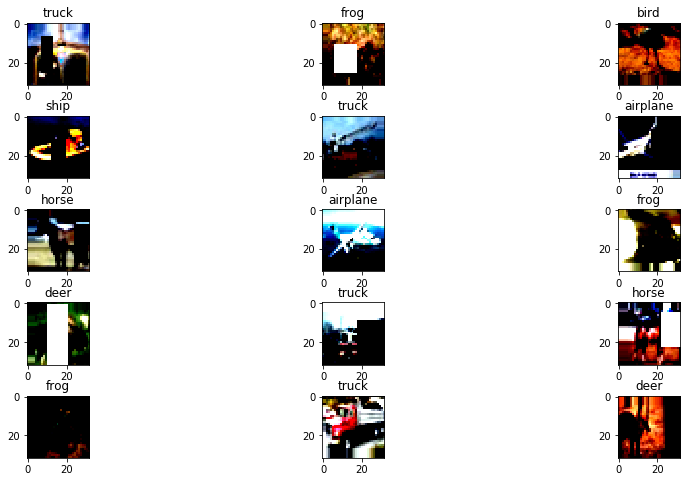

In [10]:
import random

random_images_tolook = [random.randint(0,X_train_da.shape[0]) for x in range(15)]

actual_y = np.argmax(y_train_da, axis=1)

fig, axeslist = plt.subplots(ncols = 3, nrows = len(random_images_tolook)//3 , figsize=(15,8))

for ind in range(len(random_images_tolook)):
  
  axeslist.ravel()[ind].imshow(X_train_da[random_images_tolook[ind]])
  
  axeslist.ravel()[ind].set_title(class_names[actual_y[random_images_tolook[ind]]])
  
plt.subplots_adjust(hspace = 0.5)

In [11]:
# Define the model

def conv_block(model):
  
  model.add(Convolution2D(64, 3, 3,  border_mode='same')) 
  model.add(Activation('relu'))
  
  model.add(Convolution2D(128, 3, 3, border_mode='same'))
  model.add(Activation('relu'))
  
  model.add(Dropout(0.2))
  
  model.add(Convolution2D(256, 3, 3, border_mode='same'))
  model.add(Activation('relu'))
  
  model.add(Dropout(0.4))
  model.add(Convolution2D(512, 3, 3, border_mode='same'))
  model.add(Activation('relu'))
  
  return model

def transition_block(model):
  

  model.add(Convolution2D(32, 1, 1, border_mode='same'))

  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  return model

model = resnet.ResNet18((train_features.shape[1], train_features.shape[2], train_features.shape[3]), 10)

model.summary()

W0729 02:28:49.134483 140219033536384 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0729 02:28:49.187145 140219033536384 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0729 02:28:49.195884 140219033536384 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0729 02:28:49.265426 140219033536384 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0729 02:28:49.267170

reshaping via a convolution...
reshaping via a convolution...
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
_______________________________________________

W0729 02:28:56.472448 140219033536384 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0729 02:28:57.214859 140219033536384 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model took 59.68 seconds to train


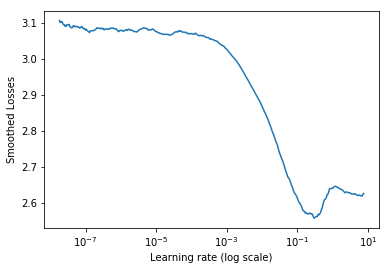

In [12]:
# Compile the model

sgd = optimizers.SGD(lr=0.01,  momentum=0.9)


model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# train the model
start = time.time()
# Train the model

bs = int(128)


step_size_clr = int(train_features.shape[0])//bs

lr_finder = LR_Finder(start_lr=1e-8, end_lr=10, step_size=step_size_clr)

"""
lr_finder = LRFinder(train_features.shape[0], bs,
                       1e-3, 1,
                       # validation_data=(X_val, Y_val),
                       lr_scale='exp', save_dir='.', verbose=0)
                       
"""
                       



model_info = model.fit_generator(datagen.flow(X_train_da, y_train_da, batch_size = bs),
                                 samples_per_epoch = train_features.shape[0], 
                                 callbacks=[lr_finder] ,verbose=0)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))

#lr_finder.plot_schedule()
lr_finder.plot_smoothed_loss()

**Setting up the learning rate and callbacks**

In [0]:
epochs = 150
max_lr = 0.1
base_lr = 0.01
max_m = 0.95
base_m = 0.85
end_percentage = 0.2

cyclical_momentum = True

decayrate = base_lr/epochs

lr_manager = OneCycleLR( max_lr = max_lr, batch_size = bs, samples = train_features.shape[0],
                        end_percentage=end_percentage, scale_percentage=None,
                        maximum_momentum=max_m, minimum_momentum=base_m)

#lr_manager = CyclicLR(base_lr = .003, max_lr = 0.1, step_size = step_size_clr, mode="triangular")
"""
lr_manager =  CyclicLR(base_lr=base_lr,
                max_lr=max_lr,
                step_size=step_size_clr,
                max_m=max_m,
                base_m=base_m,
                cyclical_momentum=cyclical_momentum)
                
"""

filepath = "assignment_13b_eva.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

sgd = optimizers.SGD(lr=base_lr,  momentum=0.9, decay=decayrate)

showlr = showLR()

**Train for 150 epochs with cyclic LR**

10.0
0.01
Epoch 1/150
time registered 1564367404.7317626
 epoch=00, lr=0.02000, time_elapsed(s)=0.00
390/390 [==============================] - 54s 138ms/step - loss: 2.7652 - acc: 0.1739 - val_loss: 2.6028 - val_acc: 0.1961

Epoch 00001: val_acc improved from -inf to 0.19610, saving model to assignment_13b_eva.hdf5
 - lr: 0.02632 - momentum: 0.95 
Epoch 2/150
 epoch=01, lr=0.02633, time_elapsed(s)=65.04
390/390 [==============================] - 48s 123ms/step - loss: 2.4006 - acc: 0.2648 - val_loss: 2.3362 - val_acc: 0.2752

Epoch 00002: val_acc improved from 0.19610 to 0.27520, saving model to assignment_13b_eva.hdf5
 - lr: 0.03265 - momentum: 0.95 
Epoch 3/150
 epoch=02, lr=0.03267, time_elapsed(s)=113.94
390/390 [==============================] - 48s 123ms/step - loss: 2.2184 - acc: 0.3296 - val_loss: 2.1216 - val_acc: 0.3527

Epoch 00003: val_acc improved from 0.27520 to 0.35270, saving model to assignment_13b_eva.hdf5
 - lr: 0.03898 - momentum: 0.95 
Epoch 4/150
 epoch=03, lr=0.

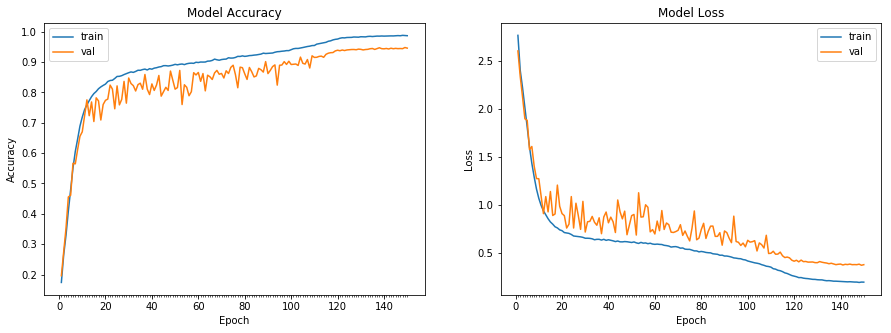

Accuracy on test data is: 94.55


In [14]:
sgd = optimizers.SGD(lr=base_lr,  momentum=0.9, decay=decayrate)


print(K.get_value(model.optimizer.lr))


model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

print(K.get_value(model.optimizer.lr))


# train the model
start = time.time()

test_iterator = datagen_test.flow(test_features, test_labels, batch_size = bs, shuffle = False)

model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = bs),
                                 samples_per_epoch = int(train_features.shape[0]), nb_epoch = epochs, 
                                 validation_data = test_iterator,
                                 validation_steps = len(test_iterator),
                                 callbacks=[checkpoint, lr_manager, showlr] ,verbose=1)

end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))

# plot model history
plot_model_history(model_info)

model.load_weights(filepath)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_iterator, model))

**Test time augmentation score**

In [20]:
model.load_weights(filepath)

num_aug_images_tta = 5

tta_accuracy(model, test_features, test_labels,  datagen_test, num_aug_images = 9)

0.9487

In [15]:
"""
model.load_weights(filepath)

print(K.get_value(model.optimizer.lr))

K.set_value(model.optimizer.lr, 0.0001)

print(K.get_value(model.optimizer.lr))

model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = bs),
                                 samples_per_epoch = int(train_features.shape[0]), nb_epoch = 15, 
                                 validation_data = test_iterator,
                                 validation_steps = len(test_iterator),
                                 callbacks=[checkpoint, showlr] ,verbose=1)


model.load_weights(filepath)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_iterator, model))
"""

'\nmodel.load_weights(filepath)\n\nprint(K.get_value(model.optimizer.lr))\n\nK.set_value(model.optimizer.lr, 0.0001)\n\nprint(K.get_value(model.optimizer.lr))\n\nmodel_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = bs),\n                                 samples_per_epoch = int(train_features.shape[0]), nb_epoch = 15, \n                                 validation_data = test_iterator,\n                                 validation_steps = len(test_iterator),\n                                 callbacks=[checkpoint, showlr] ,verbose=1)\n\n\nmodel.load_weights(filepath)\n# compute test accuracy\nprint ("Accuracy on test data is: %0.2f"%accuracy(test_iterator, model))\n'

# GradCam on mis-classified images

In [0]:
from google.colab.patches import cv2_imshow

from matplotlib import gridspec

from keras.preprocessing.image import img_to_array

import cv2

def get_gradcam(image_in, layer_name = "res5c_branch2c", num_kernels = 2048):
  

  #image_in = cv2.resize(image_in, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)

  x = img_to_array(image_in)

  x = x.reshape((1, image_in.shape[0], image_in.shape[1], image_in.shape[2]))

  #x = preprocess_input(x)

  preds = model.predict(x)

  class_idx = np.argmax(preds[0])

  #print(class_idx)

  class_output = model.output[:, class_idx]

  #print(imagenet_classes[class_idx])

  last_conv_layer = model.get_layer(layer_name)

  grads = K.gradients(class_output, last_conv_layer.output)[0]

  #print(grads.shape)

  pooled_grads = K.mean(grads, axis=(0, 1, 2))

  #print(pooled_grads.shape)

  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

  pooled_grads_value, conv_layer_output_value = iterate([x])

  for i in range(num_kernels):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

  heatmap = np.mean(conv_layer_output_value, axis = -1)

  #print(conv_layer_output_value.shape)

  #print(heatmap.shape)

  heatmap = np.maximum(heatmap, 0)

  heatmap /= np.max(heatmap)

  heatmap = cv2.resize(heatmap, (image_in.shape[1], image_in.shape[0]))

  heatmap = np.uint8(255 * heatmap)

  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

  superimposed_img = cv2.addWeighted(cv2.resize(image_in, dsize=(32, 32), interpolation=cv2.INTER_CUBIC), 0.5, heatmap, 0.5, 0, dtype = cv2.CV_32F)

  #cv2_imshow(image_in)

  #cv2_imshow(heatmap)

  #cv2_imshow(superimposed_img)
  
  return superimposed_img



def get_wrongly_classified_indices(predictions, y_vals):
  
  """
  Takes predicted and actual values
  Returns a tuple of misclassified image indexes and their corresponding predicted and actual values
  
  NOTE: Make sure your predictions are in the same order of actuals, using shuffle=False while predicting would be important
  
  Params:
  predictions: probability values of predictions
  y_vals: actual values of data
  """
  
  predicted_y = np.argmax(predictions, axis=1)
  
  actual_y = np.argmax(y_vals, axis = 1)
  
  wrong_indices = np.nonzero(~(actual_y == predicted_y))
  
  return (wrong_indices[0], predicted_y[wrong_indices[0]], actual_y[wrong_indices[0]])
  
  
def plot_figures(figures, nrows = 1, ncols=1):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig = plt.figure(figsize=(15,20))
    
    gs = gridspec.GridSpec(ncols=ncols, nrows=nrows, wspace=0.4, hspace=0, top = 0.5, bottom  = 0)
    
    for ind,title in enumerate(figures):
        
        nested_gs = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[ind], wspace=0) # 1 row, 2 columns for each cluster
        
        ax = plt.Subplot(fig, nested_gs[0])
        
        
        ax.imshow(figures[title]["image"])
        
        fig.add_subplot(ax)
        
        ax.set_title(title)
        
        ax = plt.Subplot(fig, nested_gs[1])        
        
        ax.imshow(figures[title]["grad_cam"])
        
        fig.add_subplot(ax)
        
        
    plt.subplots_adjust(hspace = 0)
    plt.show()    
    


In [22]:
import warnings
warnings.filterwarnings("ignore")

predictions = model.predict(test_features)
    
misclassified_image_idx = get_wrongly_classified_indices(predictions, test_labels)

print(misclassified_image_idx)

number_of_im = len(misclassified_image_idx[0])

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

if (number_of_im) > 25:
  number_of_im = 25

figures = {}

for i in range(number_of_im):
  
  title = str(i+1)+'.\tPredicted: '.expandtabs()+class_names[misclassified_image_idx[1][i]] + '\n\tActual: '.expandtabs() + class_names[misclassified_image_idx[2][i]]
  
  img_idx = misclassified_image_idx[0][i]
  
  image = test_features[img_idx].reshape(32,32,3)
  
  grad_cam = get_gradcam(image, layer_name = "conv2d_20", num_kernels = 256)
  
  figures[title] = {}
  
  figures[title]["image"] = image
  
  figures[title]["grad_cam"] = grad_cam
  
  #figures[title]["title"] = title
  

(array([   4,    5,    6, ..., 9993, 9995, 9998]), array([3, 3, 3, ..., 3, 5, 0]), array([6, 6, 1, ..., 5, 8, 1]))


W0729 04:40:49.288881 140219033536384 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0729 04:40:49.316290 140219033536384 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0729 04:40:49.679658 140219033536384 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0729 04:40:49.705413 140219033536384 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0729 04:40:49.729102 140219033536384 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0729 04:40:49.753503 140219033536384 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0729 04:40:49.777814 140219

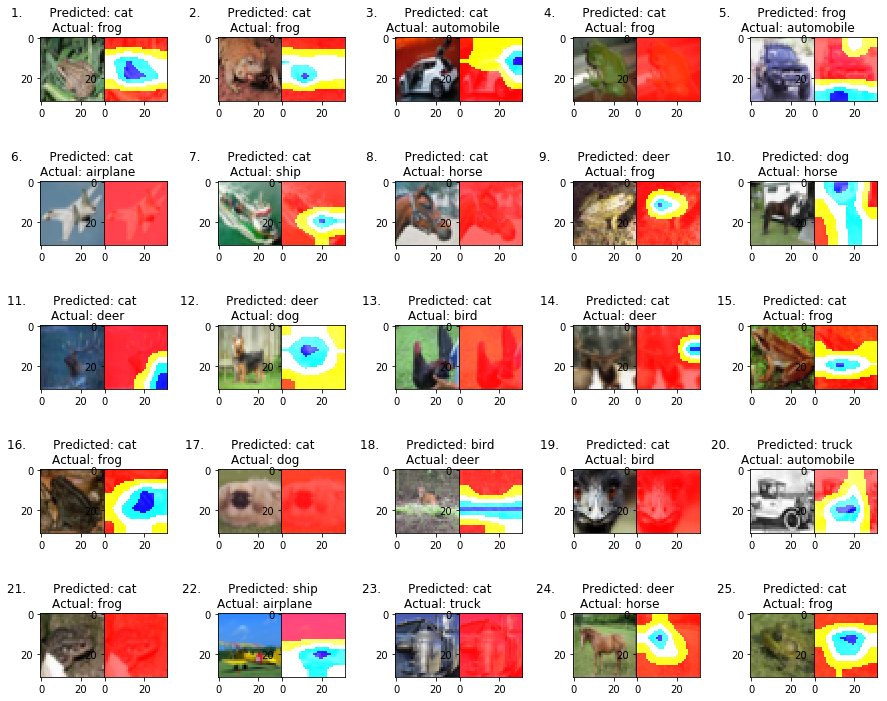

In [23]:
plot_figures(figures, 5, 5)